# Vision Quest

In [1]:
from jyro.simulator import *
from conx import *
from IPython.display import display
import random
import numpy as np

Using Theano backend.
conx, version 3.5.9


In [2]:
def make_world(physics):
    physics.addBox(0, 0, 5, 5, fill="gray", wallcolor="gray")
    physics.addBox(0, 0, 0.5, 0.5, fill="blue", wallcolor="blue")
    physics.addBox(0, 5, 0.5, 4.5 , fill="red", wallcolor="red")
    physics.addBox(4.5, 4.5, 5, 5, fill="green", wallcolor="green")
    physics.addBox(4.5, 0, 5, 0.5, fill="purple", wallcolor="purple")
    physics.addBox(2, 1.75, 2.5, 3.25, fill="orange", wallcolor="orange")
    physics.addLight(3, 2.5, 1)

def make_robot():
    robot = Pioneer("Pioneer", 3, 1, 0) 
    robot.addDevice(Camera())
    robot.addDevice(Pioneer16Sonars())
    robot.addDevice(PioneerFrontLightSensors(3))
    return robot

robot = make_robot()
robot.mystep = 0
robot.priority = random.choice(["left", "right"])
sim = Simulator(robot, make_world)

def get_quadrant(x, y, max_x=5, max_y=5):
    if x <= max_x/2 and y <= max_y/2:
        return 1
    elif x <= max_x/2 and y >= max_y/2:
        return 2
    elif x >= max_x/2 and y >= max_y/2:
        return 3
    else:
        return 4

SAMPLES = 500
    
def controller(robot):
    if robot.mystep % 200 == 0:
        robot.priority = "left" if robot.priority == "right" else "right"
    image = robot["camera"].getData()
    
    x, y, h = robot.getPose()
    quad = get_quadrant(x, y)
    
    ls = list(robot.targets)
    counts = [ls.count(n) for n in [1,2,3,4]]

    if quad > len(counts) or counts[quad-1] < SAMPLES:
        robot.images.append(image)
        robot.targets.append(quad)
    
    sonar = robot["sonar"].getData()
    left = min(sonar[0:4])
    right = min(sonar[4:8])
    clearance = 0.5
    noise = random.gauss(0, 0.2)
    if robot.priority == "left":
        if left < clearance or right < clearance:
            robot.move(0, -0.5+noise)
        else:
            robot.move(0.5+noise, 0)
    else:
        if left < clearance or right < clearance:
            robot.move(0, 0.5+noise)
        else:
            robot.move(0.5+noise, 0)
    robot.mystep += 1

robot.brain = controller 
robot.images = []
robot.targets = []


In [3]:
i = 0
while True:
    if i % 100 == 0:
        print(i, end=" ")
    #display(robot["camera"].getImage())
    sim.step(run_brain=True)
    ls = list(robot.targets)
    x = [ls.count(n) for n in [1,2,3,4]]
    if min(x) == SAMPLES:
        break
    i += 1

## Now trim all of them to same length

with open("vision_images.npy", "wb") as fp:
    np.save(fp, robot.images)
with open("vision_targets.npy", "wb") as fp:
    np.save(fp, robot.targets)
print("done collecting data")

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 done collecting data


In [4]:
!ls -l *.npy

-rw-r--r-- 1 dblank dblank 57600128 Jan 27 12:31 vision_images.npy
-rw-r--r-- 1 dblank dblank    16128 Jan 27 12:31 vision_targets.npy


In [5]:
vision_images = np.load("vision_images.npy")
print(vision_images.shape)
vision_targets = np.load("vision_targets.npy")
print(vision_targets.shape)

(2000, 40, 60, 3)
(2000,)


In [6]:
ls = list(vision_targets)
x = [ls.count(n) for n in [1,2,3,4]]
print(x)
print(sum(x))

[500, 500, 500, 500]
2000


<IPython.core.display.Javascript object>

<Network name='Vision Controller' (compiled)>
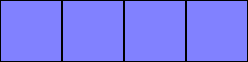
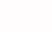
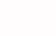
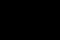

[0.2408667504787445,
 0.19407963752746582,
 0.17542071640491486,
 0.3896328806877136]

In [7]:
from conx import *
def vision_network(actf):
    net = Network("Vision Controller")
    net.add(ImageLayer("img_input", (40,60), 3))
    net.add(Conv2DLayer("conv1", 10, (5, 5), 
                        activation=actf))
    net.add(Conv2DLayer("conv2", 10, (5, 5), 
                        activation=actf))
    net.add(MaxPool2DLayer("pool1", 
                           pool_size=(2,2)))
    net.add(FlattenLayer("flatten"))
    net.add(Layer("hidden", 20, 
                  activation=actf))
    net.add(Layer("output", 4, 
                  activation="softmax"))
    net.connect()
    net.compile(loss="categorical_crossentropy", 
                optimizer="adam")
    return net

net = vision_network("relu")
net["conv1"].feature = 7
display(net)
net.propagate(vision_images[0])

In [8]:
net.propagate(vision_images[19], visualize=True)

[0.24244247376918793,
 0.20360258221626282,
 0.18065685033798218,
 0.37329810857772827]

Feature 0,Feature 1,Feature 2,Feature 3,Feature 4
Feature 5,Feature 6,Feature 7,Feature 8,Feature 9

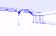
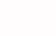
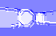
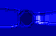
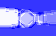
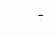
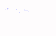
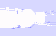
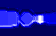
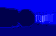

In [9]:
net.propagate_to_features("conv1", vision_images[10])

In [14]:
net.propagate_to_features("conv1", vision_images[20], html=False, visualize=True)

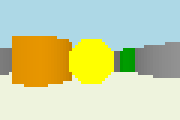

In [15]:
img = array2image(vision_images[0], scale=3.0)
img

In [16]:
net.propagate(vision_images[10])

[0.2359803318977356,
 0.20740050077438354,
 0.1849192976951599,
 0.37169986963272095]

<IPython.core.display.Javascript object>


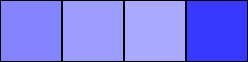
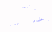
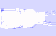
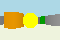

In [17]:
net.snapshot(vision_images[0])

Feature 0,Feature 1,Feature 2,Feature 3,Feature 4
Feature 5,Feature 6,Feature 7,Feature 8,Feature 9

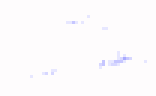
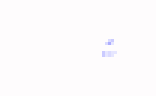
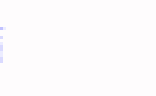
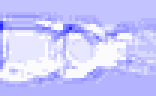
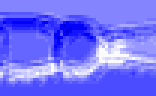
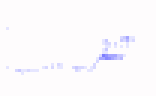
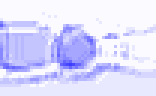
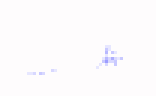
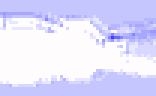
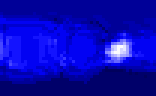

In [18]:
net.propagate_to_features("conv2", vision_images[0], scale=3.0)

In [19]:
ds = net.dataset

In [20]:
ds.clear()

In [21]:
%%time
dataset = []
for i in range(len(vision_images)):
    dataset.append([vision_images[i], onehot(vision_targets[i] - 1, 4)])
ds.load(dataset)

CPU times: user 121 ms, sys: 24 ms, total: 145 ms
Wall time: 145 ms


In [22]:
ds.shuffle()

In [23]:
ds.split(.1)

In [24]:
ds.summary()

**Dataset Split**:
   * training  : 1800
   * testing   : 200
   * total     : 2000

**Input Summary**:
   * shape  : [(40, 60, 3)]
   * range  : [(0.0, 1.0)]

**Target Summary**:
   * shape  : [(4,)]
   * range  : [(0.0, 1.0)]



In [22]:
#net.delete()
#net.train(5, report_rate=1, plot=True)
#net.save()

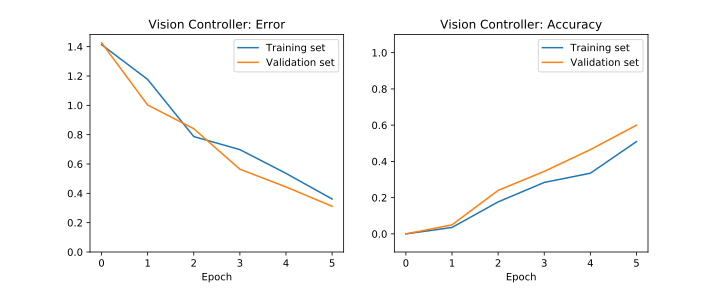

       |  Training |  Training |  Validate |  Validate 
Epochs |     Error |  Accuracy |     Error |  Accuracy 
------ | --------- | --------- | --------- | --------- 
#    5 |   0.36111 |   0.50944 |   0.31159 |   0.60000 


In [25]:
if net.saved():
    net.load()
    net.plot_loss_acc()
else:
    net.train(5, report_rate=1, plot=True)
    net.save()


In [26]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, options=('Test', 'Train'), rows=1, value='Train'), FloatSlider(value=1.0, continuous_update=False, description='Zoom', max=3.0, min=0.5), IntText(value=150, description='Horizontal space between banks:', style=DescriptionStyle(description_width='initial')), IntText(value=30, description='Vertical space between layers:', style=DescriptionStyle(description_width='initial')), HBox(children=(Checkbox(value=False, description='Show Targets', style=DescriptionStyle(description_width='initial')), Checkbox(value=False, description='Errors', style=DescriptionStyle(description_width='initial')))), Select(description='Features:', options=('', 'img_input', 'conv1', 'conv2', 'pool1'), rows=1, value=''), IntText(value=3, description='Feature columns:', style=DescriptionStyle(description_width='initial')), FloatText(value=2.0, description='Feature scale:', style=DescriptionStyle(description_width='initial'))), layout=Layout(width='100%')), VBox(children=(Select(description='Layer:', index=6, options=('img_input', 'conv1', 'conv2', 'pool1', 'flatten', 'hidden', 'output'), rows=1, value='output'), Checkbox(value=True, description='Visible'), Select(description='Colormap:', options=('', 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Vega10', 'Vega10_r', 'Vega20', 'Vega20_r', 'Vega20b', 'Vega20b_r', 'Vega20c', 'Vega20c_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spectral', 'spectral_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'viridis', 'viridis_r', 'winter', 'winter_r'), rows=1, value=''), HTML(value='<img src="data:image/gif;base64,R0lGODdhLAEZAIcAAPEBAY8AAM8AAAEB8q8AAAAAbwAAsAAAkAAA0PTo8vr3+wAAV0dH/7e3//9WVv/W1hYW/zQ0/2dn/4aG/6Sk/9nZ//8XF/82Nv9oaP+Xl/+1tSQk/1lZ/3h4/5SU/8nJ//8mJv9ERP95ef+Hh/+mpv/ExH8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

<IPython.core.display.Javascript object>

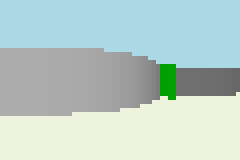

In [27]:
robot["camera"].getImage().resize((240, 160))

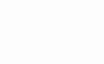

In [28]:
image = net.propagate_to_image("conv2", vision_images[0], scale=2.0)
image

Feature 0,Feature 1,Feature 2,Feature 3,Feature 4
Feature 5,Feature 6,Feature 7,Feature 8,Feature 9

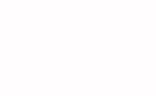
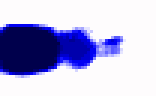
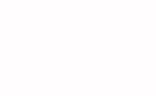
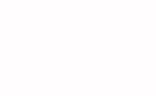
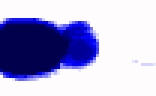
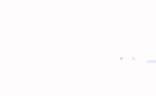
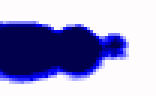
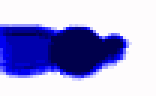
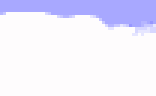
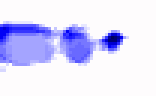

In [29]:
net.propagate_to_features("conv2", vision_images[0], scale=3.0)

In [30]:
net.propagate(vision_images[10])

[2.0572382686268043e-10,
 2.5946392270270735e-05,
 0.02174180932343006,
 0.9782322645187378]

In [31]:
net.propagate(array2image(robot["camera"].getData()))

[0.14169691503047943,
 0.39364564418792725,
 0.3407711088657379,
 0.123886339366436]

In [32]:
from conx.widgets import CameraWidget

In [33]:
cam = CameraWidget()
cam

<IPython.core.display.Javascript object>

CameraWidget()

In [34]:
image = cam.get_image().resize((60, 40))

In [35]:
net.propagate(image)

[0.2507583200931549, 0.2764703929424286, 0.1926824152469635, 0.280088871717453]

In [36]:
net.propagate(robot["camera"].getData())

[0.14169691503047943,
 0.39364564418792725,
 0.3407711088657379,
 0.123886339366436]

In [37]:
net.test()

Testing validation dataset with tolerance 0.1...
Total count: 1800
      correct: 1191
      incorrect: 609
Total percentage correct: 0.6616666666666666


In [42]:
def network_brain(robot):
    if robot.mystep % 200 == 0:
        robot.priority = "left" if robot.priority == "right" else "right"
    inputs = robot["camera"].getData()
    outputs = net.propagate(inputs)
    print(net.pf(outputs))
    sonar = robot["sonar"].getData()
    left = min(sonar[0:4])
    right = min(sonar[4:8])
    clearance = 0.5
    noise = random.gauss(0, 0.2)
    if robot.priority == "left":
        if left < clearance or right < clearance:
            robot.move(0, -0.5+noise)
        else:
            robot.move(0.5+noise, 0)
    else:
        if left < clearance or right < clearance:
            robot.move(0, 0.5+noise)
        else:
            robot.move(0.5+noise, 0)
    robot.mystep += 1

In [43]:
net.visualize = False
robot = make_robot()
robot.brain = network_brain
robot.mystep = 0
robot.priority = random.choice(["left", "right"])
vsim = VSimulator(robot, make_world)

VBox(children=(VBox(children=(HBox(children=(Checkbox(value=True, description='Update GUI'), Checkbox(value=False, description='Trace Path'), Text(value='0.0 seconds', description='Time:'))), HBox(children=(VBox(children=(HBox(children=(FloatSlider(value=0.0, layout=Layout(height='400px', padding='0px 0px 0px 0px', width='15px'), orientation='vertical', readout=False), HTML(value='<svg baseProfile="full" height="400" version="1.1" width="400" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="#bebebe" height="400.0" stroke="#bebebe" stroke-width="1" width="400.0" x="0.0" y="0.0" /><rect fill="#0000ff" height="40.0" stroke="#0000ff" stroke-width="1" width="40.0" x="0.0" y="360.0" /><rect fill="#ff0000" height="40.0" stroke="#ff0000" stroke-width="1" width="40.0" x="0.0" y="0.0" /><rect fill="#00ff00" height="40.0" stroke="#00ff00" stroke-width="1" width="40.0" x="360.0" y="0.0" /><rect fill="#a020f0" height="40.0" stroke="#a020f0" stroke-width="1" width="40.0" x="360.0" y="360.0" /><rect fill="#ffa500" height="120.0" stroke="#ffa500" stroke-width="1" width="40.0" x="160.0" y="140.0" /><circle cx="240.0" cy="200.0" fill="#ffff00" r="20.0" stroke="#ffff00" stroke-width="1" /><line fill="#800080" stroke="#a020f0" stroke-width="1" x1="240.0" x2="0.0" y1="320.0" y2="181.435928" /><line fill="#800080" stroke="#a020f0" stroke-width="1" x1="240.0" x2="400.0" y1="320.0" y2="227.623952" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="226.0" x2="0.0" y1="312.0" y2="312.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="228.0" x2="0.0" y1="306.4" y2="200.08184799999998" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="231.20000000000002" x2="194.27961618911831" y1="304.0" y2="260.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="236.0" x2="200.0" y1="302.0" y2="167.64617200000004" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="244.0" x2="324.92065769631694" y1="302.0" y2="0.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="248.79999999999998" x2="400.0" y1="304.0" y2="123.806856" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="252.0" x2="400.0" y1="306.4" y2="237.386464" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="254.0" x2="400.0" y1="312.0" y2="312.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="254.0" x2="400.0" y1="328.0" y2="328.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="252.0" x2="360.0" y1="333.6" y2="383.961228" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="248.79999999999998" x2="302.50237633014075" y1="336.0" y2="400.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="244.0" x2="260.61284965930395" y1="338.0" y2="400.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="236.0" x2="219.38715034069605" y1="338.0" y2="400.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="231.20000000000002" x2="177.49762366985925" y1="336.0" y2="400.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="228.0" x2="85.60474553604841" y1="333.6" y2="400.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="226.0" x2="0.0" y1="328.0" y2="328.0" /><line fill="#800080" stroke="#ffa500" stroke-width="1" x1="240.0" x2="226.0" y1="200.0" y2="302.0" /><line fill="#800080" stroke="#ffa500" stroke-width="1" x1="240.0" x2="254.0" y1="200.0" y2="302.0" /><polygon fill="red" points="233.6,302.0 226.0,308.0 226.0,332.0 233.6,338.0 246.4,338.0 254.0,332.0 254.0,308.0 246.4,302.0" stroke="red" stroke-width="1" /><polygon points="-4.0,-4.0 0,0 4.0,-4.0 0,4.0" stroke="black" stroke-width="1" transform="translate(240.0,320.0) rotate(180.0)" /><polygon fill="black" points="244.8,308.8 244.8,315.2 235.2,315.2 235.2,308.8" stroke="black" stroke-width="1" /><circle cx="226.0" cy="302.0" fill="yellow" r="2.0" stroke="orange" stroke-width="1" /><circle cx="254.0" cy="302.